In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor

In [2]:
#Load Dataset

DoorDash_data = pd.read_csv("datasets/historical_data.csv")
DoorDash_data["created_at"] = pd.to_datetime(DoorDash_data["created_at"])
DoorDash_data["actual_delivery_time"]=pd.to_datetime(DoorDash_data["actual_delivery_time"])

DoorDash_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
#Add features and target variables
DoorDash_data["actual_delivery_duration"]= DoorDash_data["actual_delivery_time"] - DoorDash_data["created_at"]
DoorDash_data.dropna(axis=0, subset=['actual_delivery_duration'],inplace=True)

DoorDash_data["busy_dashers_ratio"]= DoorDash_data["total_busy_dashers"]/DoorDash_data["total_onshift_dashers"]
DoorDash_data["estimated_non_prep_duration"] = DoorDash_data["estimated_order_place_duration"]+DoorDash_data["estimated_store_to_consumer_driving_duration"]
DoorDash_data.head()
DoorDash_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197421 entries, 0 to 197427
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype          
---  ------                                        --------------   -----          
 0   market_id                                     196434 non-null  float64        
 1   created_at                                    197421 non-null  datetime64[ns] 
 2   actual_delivery_time                          197421 non-null  datetime64[ns] 
 3   store_id                                      197421 non-null  int64          
 4   store_primary_category                        192661 non-null  object         
 5   order_protocol                                196426 non-null  float64        
 6   total_items                                   197421 non-null  int64          
 7   subtotal                                      197421 non-null  int64          
 8   num_distinct_items                            197

*Preprocessing Data*

In [4]:
#Look if store_id, market_id, order_protocol should be onehotencoded by finding the number of unique values
print(DoorDash_data["market_id"].nunique())
print(DoorDash_data["order_protocol"].nunique())
print(DoorDash_data["store_id"].nunique())

6
7
6743


In [5]:
#Create dummies for market id
market_id_dummies = pd.get_dummies(DoorDash_data['market_id'])
market_id_dummies = market_id_dummies.add_prefix("market_id_")

#Create dummies for order_protocol
order_protocol_dummies = pd.get_dummies(DoorDash_data['order_protocol'])
order_protocol_dummies = order_protocol_dummies.add_prefix("order_protocol_")

#Create dummies for store_primary_category
store_primary_category_dummies = pd.get_dummies(DoorDash_data['store_primary_category'])
store_primary_category_dummies = store_primary_category_dummies.add_prefix("category")

DoorDash_data = pd.concat([DoorDash_data,order_protocol_dummies,market_id_dummies,store_primary_category_dummies],axis=1)

#Handling missing and infinite values
DoorDash_data.replace([np.inf,-np.inf],np.nan,inplace=True)
DoorDash_data.dropna(inplace=True)

train_df = DoorDash_data.drop(columns=["created_at","market_id","order_protocol","actual_delivery_time","store_primary_category"])

train_df.head()

,store_id,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,...,categorysouthern,categoryspanish,categorysteak,categorysushi,categorytapas,categorythai,categoryturkish,categoryvegan,categoryvegetarian,categoryvietnamese
0,1845,4,3441,4,557,1239,33.0,14.0,21.0,446,...,False,False,False,False,False,False,False,False,False,False
1,5477,1,1900,1,1400,1400,1.0,2.0,2.0,446,...,False,False,False,False,False,False,False,False,False,False
8,5477,4,4771,3,820,1604,8.0,6.0,18.0,446,...,False,False,False,False,False,False,False,False,False,False
14,2841,1,1525,1,1525,1525,5.0,6.0,8.0,446,...,False,False,False,False,False,False,False,False,False,False
15,2841,2,3620,2,1425,2195,5.0,5.0,7.0,446,...,False,False,False,False,False,False,False,False,False,False


In [6]:
duplicates = train_df.columns[train_df.columns.duplicated()]
print("Duplicate columns:", duplicates)

Duplicate columns: Index([], dtype='object')


*Finding Collinear Features And Removing Redundancies*

<Axes: >

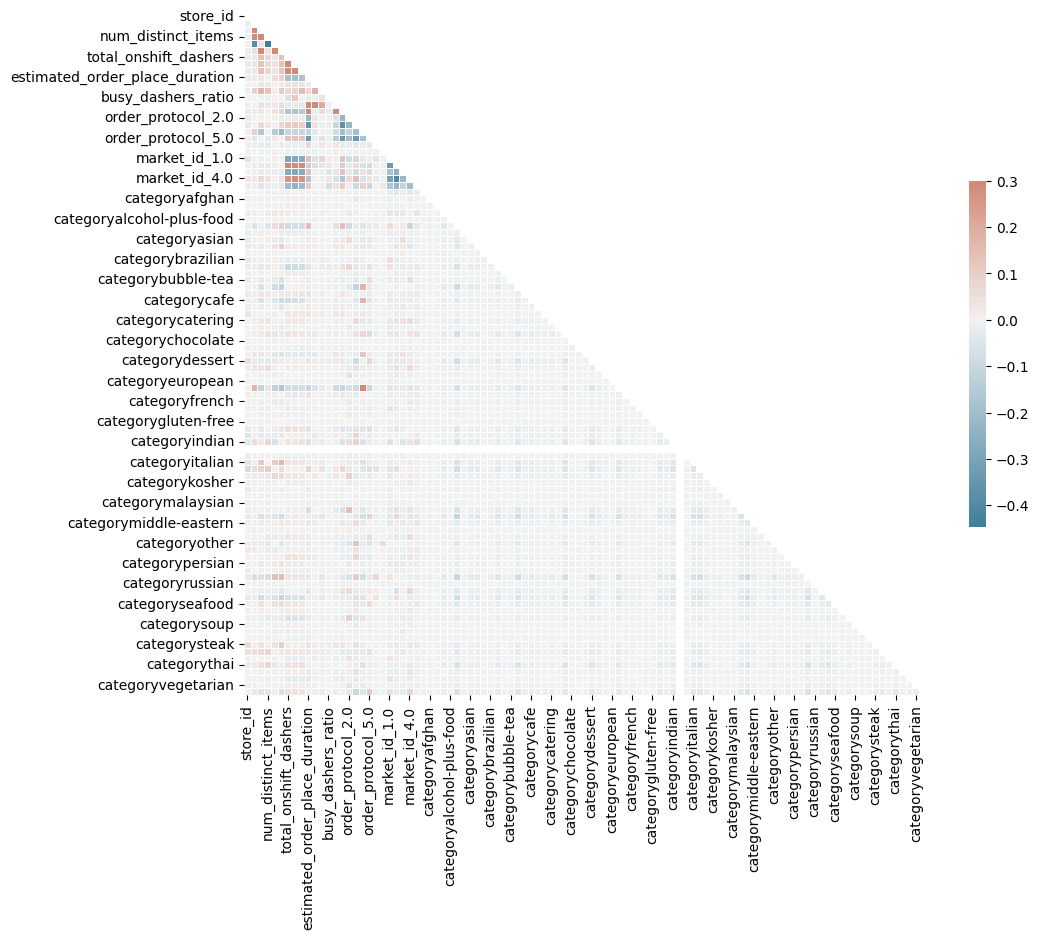

In [7]:
corr = train_df.corr()  #Compute the correlation matrix
mask = np.triu(np.ones_like(corr,dtype=bool))
#Set up graph
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20,as_cmap=True)
#Draw the map
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5})

In [8]:
def get_redundant_pairs(df):
    #Get diagonal and lower traingle pairs of correlation matrix
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0,df.shape[1]):
        for j in range(0,i+1):
            pairs_to_drop.add((cols[j],cols[i]))
    return pairs_to_drop

def get_tops_abs_correlations(df,n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_tops_abs_correlations(train_df,20))

Top Absolute Correlations
total_busy_dashers           total_onshift_dashers                           0.941705
total_outstanding_orders     total_onshift_dashers                           0.934585
                             total_busy_dashers                              0.931193
estimated_non_prep_duration  estimated_store_to_consumer_driving_duration    0.924029
order_protocol_1.0           estimated_order_place_duration                  0.901261
num_distinct_items           total_items                                     0.756611
                             subtotal                                        0.682417
subtotal                     total_items                                     0.554731
max_item_price               min_item_price                                  0.540044
                             subtotal                                        0.509098
categoryfast                 order_protocol_4.0                              0.500220
min_item_price              

In [9]:
train_df = train_df.drop(columns=["total_onshift_dashers","total_busy_dashers","estimated_non_prep_duration","order_protocol_1.0","categoryindonesian"])

print("Top Absolute Correlations")
print(get_tops_abs_correlations(train_df,20))
#train_df = train_df.astype("float32")

Top Absolute Correlations
num_distinct_items  total_items                       0.756611
                    subtotal                          0.682417
subtotal            total_items                       0.554731
max_item_price      min_item_price                    0.540044
                    subtotal                          0.509098
categoryfast        order_protocol_4.0                0.500220
min_item_price      num_distinct_items                0.447435
market_id_4.0       market_id_2.0                     0.405842
min_item_price      total_items                       0.389421
order_protocol_3.0  estimated_order_place_duration    0.362506
order_protocol_5.0  order_protocol_3.0                0.338690
market_id_2.0       market_id_1.0                     0.338291
order_protocol_5.0  estimated_order_place_duration    0.332466
market_id_4.0       market_id_1.0                     0.305314
market_id_2.0       total_outstanding_orders          0.287002
market_id_4.0       total_out

In [10]:
#Feature Engineering
train_df["percent_distinct_item_of_toal"]= train_df["num_distinct_items"]/train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"]/train_df["total_items"]
train_df["price_range_item"] = train_df["max_item_price"]-train_df["min_item_price"]
train_df.drop(columns=["num_distinct_items","subtotal","min_item_price","max_item_price"],inplace=True)
print("Top Absolute Correlations")
print(get_tops_abs_correlations(train_df,20))
train_df.head()

Top Absolute Correlations
categoryfast                   order_protocol_4.0                0.500220
percent_distinct_item_of_toal  total_items                       0.444545
market_id_4.0                  market_id_2.0                     0.405842
order_protocol_3.0             estimated_order_place_duration    0.362506
order_protocol_5.0             order_protocol_3.0                0.338690
market_id_2.0                  market_id_1.0                     0.338291
price_range_item               total_items                       0.332925
order_protocol_5.0             estimated_order_place_duration    0.332466
avg_price_per_item             total_items                       0.310489
market_id_4.0                  market_id_1.0                     0.305314
market_id_2.0                  total_outstanding_orders          0.287002
market_id_4.0                  total_outstanding_orders          0.270032
market_id_3.0                  total_outstanding_orders          0.263800
market_id_1.

,store_id,total_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_dashers_ratio,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,...,categorysushi,categorytapas,categorythai,categoryturkish,categoryvegan,categoryvegetarian,categoryvietnamese,percent_distinct_item_of_toal,avg_price_per_item,price_range_item
0,1845,4,21.0,446,861.0,0 days 01:02:59,0.424242,False,False,False,...,False,False,False,False,False,False,False,1.00,860.25,682
1,5477,1,2.0,446,690.0,0 days 01:07:04,2.000000,True,False,False,...,False,False,False,False,False,False,False,1.00,1900.00,0
8,5477,4,18.0,446,289.0,0 days 00:26:26,0.750000,False,True,False,...,False,False,False,False,False,False,False,0.75,1192.75,784
14,2841,1,8.0,446,795.0,0 days 00:37:53,1.200000,False,False,False,...,False,False,False,False,False,False,False,1.00,1525.00,0
15,2841,2,7.0,446,205.0,0 days 00:49:48,1.000000,False,False,False,...,False,False,False,False,False,False,False,1.00,1810.00,770


In [11]:
#Convert nanoseconds to minutes
train_df["actual_delivery_duration"] = train_df["actual_delivery_duration"].dt.total_seconds() / 60
Y = train_df.actual_delivery_duration
X = train_df[train_df.drop(["actual_delivery_duration"],axis=1).columns]

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)

In [ ]:
model = XGBRegressor(n_estimators=500,learning_rate=0.1,early_stopping_rounds=15,random_state=42)
model.fit(X_train,Y_train,eval_set=[(X_valid, Y_valid)],verbose=False)

preds = model.predict(X_valid)
error = mean_absolute_error(Y_valid,preds)
print(error)

11.287807573344173


*Simplify Model*

In [13]:
#Extract feature importances
importances = model.feature_importances_

# Pair each feature name with its importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort descending
importance_df = importance_df.sort_values(by='Importance', ascending=False)

low_importance_features = importance_df[importance_df['Importance'] < 0.00035]['Feature'].tolist()

X_train_reduced = X_train.drop(columns=low_importance_features)
X_reduced_valid = X_valid.drop(columns=low_importance_features)

final_model = XGBRegressor(n_estimators=500,learning_rate=0.1,early_stopping_rounds=15,random_state=42)
final_model.fit(X_train_reduced,Y_train,eval_set=[(X_reduced_valid, Y_valid)],verbose=False)

#scores = -1 * cross_val_score(model,X,Y, cv=5, scoring='neg_mean_absolute_error')

preds = final_model.predict(X_reduced_valid)
error = mean_absolute_error(Y_valid,preds)
print(f"Error: {error}")
print(importance_df.head(10))

Error: 11.203733830773842
                                         Feature  Importance
54                                categoryindian    0.252167
12                                 market_id_1.0    0.173025
7                             order_protocol_3.0    0.087893
5                             busy_dashers_ratio    0.064580
2                       total_outstanding_orders    0.026351
92                            avg_price_per_item    0.020445
4   estimated_store_to_consumer_driving_duration    0.020122
3                 estimated_order_place_duration    0.017532
13                                 market_id_2.0    0.017478
10                            order_protocol_6.0    0.013719


*Save the Model*

In [14]:
import joblib

joblib.dump(final_model,"model.joblib")

['model.joblib']